Car License Plate Reader - Overview
1. Input Image
2. Grayscale Image
3. Binarize Image
4. Plate Localization
5. Character Segmentation
6. Character Recognition

In [111]:
# Author: Luke O'Shea Scanlan, Panagiotis Bampilis
# Module: Image Processing 2023-2024
# Group Project

import cv2
import numpy as np
from matplotlib import pyplot as plt

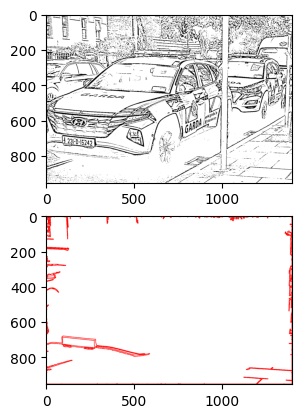

In [112]:
"""
This project aims to give the user the ability to input any sample images of car license plates
and return the results as a text output.

The product is capable of recognising car license plates rotated, as well as a certain amount of blurriness.

"""

# Input Image
I = cv2.imread("Sample Inputs/gardai_cars.jpg")

# Grayscale Image
G = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

# Binarize Image
# _, B = cv2.threshold(G, 190, 255, cv2.THRESH_BINARY)

# Adaptive Threshold
B = cv2.adaptiveThreshold(G, maxValue = 255,adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C, thresholdType = cv2.THRESH_BINARY, blockSize = 25,C = 20)

# Creating empty canvas to fill mask in
canvas = np.zeros(I.shape, np.uint8)
canvas.fill(255)

# Creating mask to fill in the contours
mask = np.zeros(I.shape, np.uint8)
mask.fill(255)
contours_mask = cv2.findContours(B, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Fill in with red lined contours
contours = cv2.findContours(B, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(mask, contours[0], -1, (255, 0, 0), 2) 

# For loop to be used to mask out the license plates number
# for c in contours:
#     if contours == 0:
        # canvas = cv2.fillConvexPoly(mask, contours_mask[contours], (0, 0, 0,))

fig, args = plt.subplots(2, 1)
args[0].imshow(B, cmap='gray')
args[1].imshow(mask)
